Evaluate the results from the optimisation of the mechanistic glycolysis model.


-- DEPRACATED!

The functions, code is not up to date and probably does not match. Use evaluate.py for orientation.

In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pypesto

from utils import *
from _hyperparameters import pairs
from load_problem import petab_problems, pypesto_problems

base_dir = Path(".").resolve().parents[1]
sys.path.append(str(base_dir / "1_mechanistic_model"))

/tmp/ipykernel_1172546/2078947311.py:10: DeprecationWarning: Accessing `petab.Problem` is deprecated and will be removed in the next major release. Please use `petab.v1.Problem` instead.
  from load_problem import petab_problems, pypesto_problems
Visualization table not available. Skipping.
/tmp/ipykernel_1172546/2078947311.py:10: DeprecationWarning: Accessing `petab.Problem` is deprecated and will be removed in the next major release. Please use `petab.v1.Problem` instead.
  from load_problem import petab_problems, pypesto_problems
Visualization table not available. Skipping.
/tmp/ipykernel_1172546/2078947311.py:10: DeprecationWarning: Accessing `petab.Problem` is deprecated and will be removed in the next major release. Please use `petab.v1.Problem` instead.
  from load_problem import petab_problems, pypesto_problems
Visualization table not available. Skipping.


20


/tmp/ipykernel_1172546/2078947311.py:10: DeprecationWarning: Accessing `petab.Problem` is deprecated and will be removed in the next major release. Please use `petab.v1.Problem` instead.
  from load_problem import petab_problems, pypesto_problems
Visualization table not available. Skipping.
/tmp/ipykernel_1172546/2078947311.py:10: DeprecationWarning: Accessing `petab.Problem` is deprecated and will be removed in the next major release. Please use `petab.v1.Problem` instead.
  from load_problem import petab_problems, pypesto_problems
Visualization table not available. Skipping.
/tmp/ipykernel_1172546/2078947311.py:10: DeprecationWarning: Accessing `petab.Problem` is deprecated and will be removed in the next major release. Please use `petab.v1.Problem` instead.
  from load_problem import petab_problems, pypesto_problems
Visualization table not available. Skipping.
/tmp/ipykernel_1172546/2078947311.py:10: DeprecationWarning: Accessing `petab.Problem` is deprecated and will be removed in 

In [2]:
dir_output = Path(".").resolve() / "output"

In [3]:
# remove the 25er data sets
pairs = [p for p in pairs if not p[1] == 25]

# load the opt results
results = {
    "%d_%d" % pair: pypesto.store.read_result(
        dir_output / ("%d_%d" % pair) / "result.hdf5", optimize=True,
    ) for pair in pairs
}

/home/maren/Documents/ude_pipeline/venv/lib/python3.10/site-packages/pypesto/store/read_from_hdf5.py:304: UserWarning: You are loading a problem. This problem is not to be used without a separately created objective.
  result.problem = pypesto_problem_reader.read()


In [4]:
# # create waterfall plots
# for pair, result in results.items():
#     pypesto.visualize.waterfall(result, size=(8, 5))
#     plt.savefig(dir_output / pair / "waterfall.svg")
#     plt.close()
# 

In [5]:
# create parameters plots
for pair, result in results.items():
    pypesto.visualize.parameters(result, size=(8, 5))
    plt.savefig(dir_output / pair / "parameters.svg")
    plt.close()


In [6]:
from pypesto.visualize.model_fit import visualize_optimized_model_fit
# create fits
for pair_id, result in results.items():
    noise, n_dp = pair_id.split("_")
    petab_problem = petab_problems[int(noise)][int(n_dp)]
    pypesto_problem = pypesto_problems[int(noise)][int(n_dp)]
    visualize_optimized_model_fit(
        petab_problem=petab_problem,
        result=result, 
        pypesto_problem=pypesto_problem,
    )
    plt.savefig(dir_output / pair_id / "fit.svg")
    plt.close()


/tmp/ipykernel_1172546/1197597308.py:1: DeprecationWarning: Accessing `petab.Problem` is deprecated and will be removed in the next major release. Please use `petab.v1.Problem` instead.
  from pypesto.visualize.model_fit import visualize_optimized_model_fit


<BarContainer object of 16 artists>

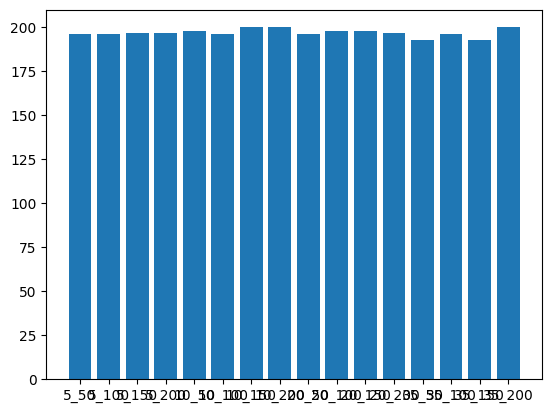

In [7]:
converged = [
    res.optimize_result.as_dataframe().message.value_counts()[
        "Converged according to fval difference"
    ] for res in results.values()
]
plt.bar(results.keys(), converged)

In [8]:
reference = get_reference()
OBSERVED = ["N_2", "A_3"]

In [9]:
# calculate the test loss for each result

for pair_id, result in results.items():
    noise, n_dp = pair_id.split("_")

    petab_problem = petab_problems[int(noise)][int(n_dp)]
    pypesto_problem = pypesto_problems[int(noise)][int(n_dp)]

    # iterate over starts
    for res in result.optimize_result:
        theta = res.x

        if theta is None: 
            res["NMSE_test"] = None
            for obs in OBSERVED:
                res[f"NMSE_test_{obs}"] = None
            continue

        # get opt. parameters on linear scale
        # scales = pypesto_problem.x_scales
        # theta_lin = [unscale(p, scale) for p, scale in zip(theta, scales)]

        # simulate
        sim = simulate_optimised_model(pypesto_problem, theta)

        # calculate test losses
        res["NMSE_test"] = NMSE_observables(theta, pypesto_problem)
        for obs in OBSERVED:
            res[f"NMSE_test_{obs}"] = NMSE(
                sim.query("time > @TRAINING_ENDPOINT")[obs], 
                reference.query("time > @TRAINING_ENDPOINT")[obs],
            )

## Visualisation

In [ ]:
for pair_id, result in results.items():
    noise, n_dp = pair_id.split("_")
    print(n_dp, noise)

    # fval and nmse
    fp = dir_output / pair_id / "fvals_nmses.svg"
    fig, ax = plot_fval_nmse(result, noise, n_dp)
    fig.savefig(fp)
    plt.close()

    # best fit
    petab_problem = petab_problems[int(noise)][int(n_dp)]
    pypesto_problem = pypesto_problems[int(noise)][int(n_dp)]
    # get opt. parameters on linear scale
    x_scaled = result.optimize_result[0].x
    scales = pypesto_problem.x_scales
    x_lin = [unscale(p, scale) for p, scale in zip(x_scaled, scales)]
    
    fp = dir_output / pair_id / "prediction.svg"
    # fig, ax = plot_fit(petab_problem, pypesto_problem, theta)
    fig, ax = plot_fit(petab_problem, pypesto_problem, x_lin, noise, n_dp)
    fig.savefig(fp)
    fig.show()
    

In [10]:
best_train = {
    key: [
        res.optimize_result[0].fval,
    ] for key, res in results.items()}

best_test = {
    key: [
        res.optimize_result[0].NMSE_test,
    ] for key, res in results.items()}

In [11]:
# NLLH for training
df_train = pd.DataFrame(best_train, index=["loss"]).T.reset_index(names="pair")
df_train[["noise", "datapoints"]] = df_train['pair'].str.split('_', expand=True)
df_train.drop(columns=["pair"], inplace=True)
df_train[["noise", "datapoints"]] = df_train[["noise", "datapoints"]].astype(int)
# for visualisation, normalise w.r.t. the number of measurements
df_train["loss_normalised"] = df_train["loss"] / df_train["datapoints"]

# NMSE for test
df_test = pd.DataFrame(best_test, index=["loss"]).T.reset_index(names="pair")
df_test[["noise", "datapoints"]] = df_test['pair'].str.split('_', expand=True)
df_test.drop(columns=["pair"], inplace=True)
df_test[["noise", "datapoints"]] = df_test[["noise", "datapoints"]].astype(int)

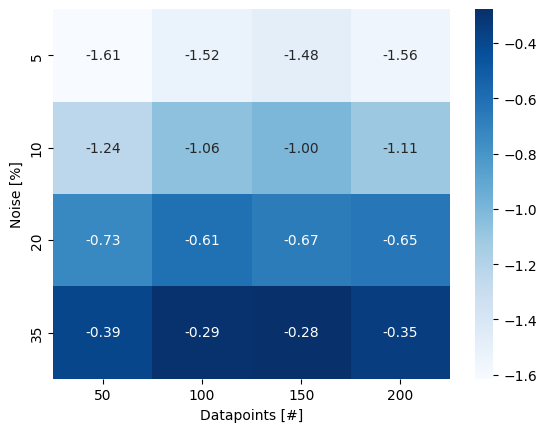

In [12]:
ax = sns.heatmap(
    df_train.pivot(index="noise", columns="datapoints", values="loss_normalised"), 
    annot=True, fmt=".2f",
    cmap="Blues"
)
ax.set(xlabel="Datapoints [#]", ylabel="Noise [%]");

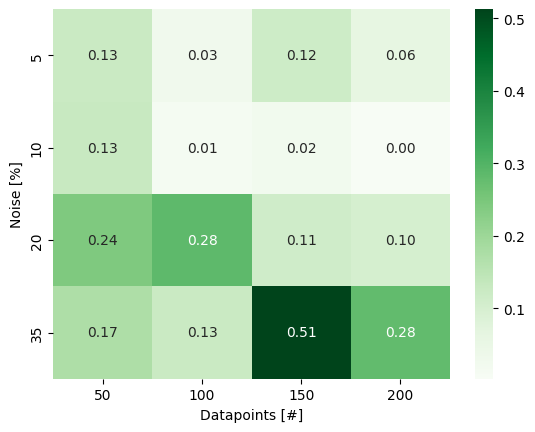

In [13]:
ax = sns.heatmap(
    df_test.pivot(index="noise", columns="datapoints", values="loss"), 
    annot=True, fmt=".2f",
    cmap="Greens"
);
ax.set(xlabel="Datapoints [#]", ylabel="Noise [%]");